Neste notebook, veremos como implementar um exemplo simples de uma rede neural híbrida clássico-quântica. Para isso, utilizaremos o PyTorch e o PennyLane.

Informações sobre a instalação de ambos podem ser encontradas, respectivamente, nos seguintes links:

https://pennylane.ai/install

https://pytorch.org/

**Observação**: Caso deseje utilizar este notebook no Google Colab, inicie executando o seguinte comando. Essa linha serve para instalar o PennyLane. O PyTorch, por padrão, já vem instalado na plataforma.


In [1]:
!pip install pennylane

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.1/56.1 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 22.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 930.8/930.8 kB 21.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 29.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 21.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.9/167.9 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 26.1 MB/s eta 0:00:00


Inicialmente, devemos importar todas as bibliotecas que serão utilizadas. Isso é feito a seguir:

In [2]:
# Importando o PyTorch, uma biblioteca muito usada para construir e treinar redes neurais clássicas
import torch

# Importando utilitários para trabalhar com conjuntos de dados de imagens (como MNIST)
from torchvision import datasets, transforms

# DataLoader ajuda a carregar os dados em mini-lotes (batches) para o treinamento
# Subset permite selecionar uma parte do conjunto de dados, útil para testes rápidos
from torch.utils.data import DataLoader, Subset

# Biblioteca NumPy, usada para operações numéricas com arrays
import numpy as np

# Importando módulos para construir a arquitetura da rede neural clássica
import torch.nn as nn  # Para definir camadas da rede
import torch.nn.functional as F  # Para funções de ativação como ReLU, etc.

# Biblioteca para plotar gráficos (por exemplo, para visualizar perda ou imagens)
import matplotlib.pyplot as plt

# Módulo de otimização do PyTorch (como o otimizador Adam)
import torch.optim as optim

# PennyLane é uma biblioteca para computação quântica híbrida
# Ela permite criar circuitos quânticos e conectá-los com redes neurais clássicas (como as do PyTorch)
import pennylane as qml


Neste notebook, utilizaremos nosso modelo híbrido para resolver um problema de classificação. Especificamente, usaremos o dataset MNIST, que consiste em um conjunto de dígitos manuscritos, com 60.000 imagens para treinamento e 10.000 para teste. Cada imagem é representada por uma matriz de dimensão $28 \times 28$, e cada uma delas corresponde a um dígito de 0 a 9.

Atualmente, devido às limitações tecnológicas, a maioria dos estudos envolvendo modelos de aprendizado de máquina quântico é realizada em computadores clássicos. Isso torna a simulação desses modelos bastante custoso. Por esse motivo, é comum que trabalhos que utilizam o MNIST empreguem apenas uma parte do conjunto de dados, em vez de usá-lo por completo.

Seguindo essa abordagem, neste estudo também utilizaremos apenas uma parte do MNIST. Especificamente, criaremos subconjuntos de dados de treinamento e teste contendo apenas imagens dos dígitos 0, 1 e 2. A função a seguir é responsável por criar esses subconjuntos.

In [3]:
def load_mnist_filtered(train_size, test_size, batch_size):
    """
    Função que carrega o conjunto de dados MNIST, mas apenas com os dígitos 0, 1 e 2.
    As imagens são achatadas (flattened) em vetores de 784 posições (28x28 pixels viram uma linha com 784 números).

    Parâmetros:
    - train_size (int): número de imagens que queremos usar para treinar a rede
    - test_size (int): número de imagens que queremos usar para testar a rede
    - batch_size (int): quantas imagens serão passadas por vez para a rede durante o treinamento (isso é chamado de "batch")

    Retorna:
    - train_loader: objeto que permite carregar os dados de treinamento em mini-lotes
    - test_loader: objeto que permite carregar os dados de teste em mini-lotes
    """

    # Aqui criamos uma transformação que será aplicada a cada imagem do MNIST.
    # 1. ToTensor() transforma a imagem em um tensor (estrutura usada pelo PyTorch).
    # 2. Lambda achata a imagem de 28x28 para um vetor de tamanho 784 (28*28 = 784).
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Lambda(lambda x: x.view(-1))  # Achata a imagem: de 1x28x28 para (784,)
    ])

    # Baixamos o conjunto de dados MNIST, tanto de treino quanto de teste.
    # Os dados são automaticamente transformados com o que definimos acima.
    full_train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
    full_test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

    # Essa função filtra apenas as imagens que representam os dígitos 0, 1 e 2
    def filter_digits(dataset):
        # Cria uma lista de índices onde os rótulos (targets) são 0, 1 ou 2
        indices = np.where(np.isin(dataset.targets, [0, 1, 2]))[0]
        # Usa apenas os dados com esses índices
        return Subset(dataset, indices)

    # Aplica o filtro nos conjuntos de treino e teste
    filtered_train = filter_digits(full_train_dataset)
    filtered_test = filter_digits(full_test_dataset)

    # Essa função pega aleatoriamente 'size' exemplos do conjunto filtrado
    def get_subset(subset, size):
        # Gera uma permutação aleatória dos índices e seleciona os 'size' primeiros
        indices = torch.randperm(len(subset))[:size]
        # Retorna apenas os exemplos selecionados
        return Subset(subset, indices)

    # Criamos conjuntos menores de treino e teste com a quantidade de exemplos que foi passada
    small_train_dataset = get_subset(filtered_train, train_size)
    small_test_dataset = get_subset(filtered_test, test_size)

    # Agora criamos os "DataLoaders", que vão nos ajudar a carregar os dados em mini-lotes (batches)
    # Durante o treino usamos shuffle=True para embaralhar os dados, o que ajuda no aprendizado
    train_loader = DataLoader(small_train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(small_test_dataset, batch_size=batch_size, shuffle=False)

    # Retornamos os dois carregadores de dados
    return train_loader, test_loader


A seguir, definimos uma função chamada ``train_model``. Essa função receberá nosso modelo e será responsável por realizar o seu treinamento. Para isso, utilizaremos a função de custo **entropia cruzada** e o otimizador **Adam**.

In [10]:
# Esta função treina o modelo em um conjunto de dados por várias épocas (repetições sobre o conjunto de treino).
def train_model(model, train_loader, test_loader, num_epochs=10, lr = 0.001, device='cpu'):
    # Move o modelo para o dispositivo escolhido (CPU ou GPU, se disponível)
    model = model.to(device)

    # Define a função de perda (ou função de custo).
    # CrossEntropyLoss é comum em problemas de classificação multiclasse.
    criterion = nn.CrossEntropyLoss()

    # Define o otimizador, que atualiza os pesos da rede.
    # Aqui usamos o Adam, que é um dos otimizadores mais usados atualmente.
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    # Listas para armazenar a evolução do loss e da acurácia
    train_losses = []
    test_accuracies = []

    # Loop principal de treinamento, onde a rede aprende
    for epoch in range(num_epochs):
        model.train()  # Coloca o modelo em modo de treinamento (ativa dropout, batchnorm, etc.)
        total_loss = 0
        correct = 0
        total = 0

        # Percorre os dados de treino em mini-lotes
        for images, labels in train_loader:
            # Move os dados para o mesmo dispositivo da rede
            images, labels = images.to(device), labels.to(device)

            # Zera os gradientes antigos antes de calcular novos
            optimizer.zero_grad()

            # Passa as imagens pela rede para obter a previsão (logits)
            outputs = model(images)

            # Calcula o custo entre a saída da rede e os rótulos corretos
            loss = criterion(outputs, labels)

            # Calcula os gradientes (backpropagation)
            loss.backward()

            # Atualiza os pesos da rede com base nos gradientes calculados
            optimizer.step()

            # Soma o custo desse mini-lote ao total
            total_loss += loss.item()

            # Calcula o número de acertos
            _, predicted = outputs.max(1)  # Pega o índice da classe com maior valor (logit)
            total += labels.size(0)       # Total de exemplos vistos até agora
            correct += predicted.eq(labels).sum().item()  # Quantos estavam corretos

        # Calcula a média da perda na época
        avg_loss = total_loss / len(train_loader)

        # Calcula a acurácia de treino na época
        train_acc = 100. * correct / total

        # Armazena o loss e a acurácia para visualizar depois
        train_losses.append(avg_loss)

        # Avalia a rede nos dados de teste (sem ajustar os pesos)
        test_acc = evaluate_model(model, test_loader, device)
        test_accuracies.append(test_acc)

        # Mostra o desempenho da época atual
        print(f"Época [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, Acurácia Treino: {train_acc:.2f}%, Acurácia Teste: {test_acc:.2f}%")

    # Mostra gráficos com os resultados
    plot_metrics(train_losses, test_accuracies)

    return train_losses, test_accuracies


# Esta função avalia o desempenho da rede no conjunto de teste
def evaluate_model(model, test_loader, device='cpu'):
    model.eval()  # Coloca o modelo em modo de avaliação (desativa dropout, etc.)
    correct = 0
    total = 0

    # Evita calcular gradientes, o que economiza memória e acelera a execução
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            # Passa as imagens pela rede
            outputs = model(images)

            # Obtém a classe com maior valor predito
            _, predicted = torch.max(outputs.data, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # Retorna a acurácia em porcentagem
    acc = 100. * correct / total
    return acc


# Esta função exibe dois gráficos: um da função de custo e outro da acurácia
def plot_metrics(train_losses, test_accuracies):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12, 5))  # Cria uma figura com duas áreas de gráfico

    # Gráfico da função de custo (loss)
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, marker='o', label='Loss Treino')
    plt.title("Função de Custo (Loss) por Época")
    plt.xlabel("Época")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.legend()

    # Gráfico da acurácia no teste
    plt.subplot(1, 2, 2)
    plt.plot(epochs, test_accuracies, marker='o', color='green', label='Acurácia Teste')
    plt.title("Acurácia no Teste por Época")
    plt.xlabel("Época")
    plt.ylabel("Acurácia (%)")
    plt.grid(True)
    plt.legend()

    plt.tight_layout()  # Ajusta os gráficos para não se sobreporem
    plt.show()


Agora, criaremos nosso modelo híbrido. Primeiro, definimos a camada quântica do modelo. Nessa etapa, os dados de entrada serão codificados em um estado quântico utilizando a **codificação em qubit**. Isso é feito usando o seguinte comando: ``qml.AngleEmbedding(features=inputs, wires=range(n), rotation='Y')``

O código a seguir define a nossa camada quântica:

In [5]:
# Define uma função que cria uma camada quântica personalizada para usar com o PyTorch
# n: número de qubits (também chamados de "fios" ou "wires")
# L: número de camadas (ou repetições) no circuito quântico
def qlayer1(n, L):

    # Cria um dispositivo simulado (default.qubit), que emula um computador quântico
    # Esse dispositivo terá 'n' qubits disponíveis
    dev = qml.device('default.qubit', wires=n)

    # Define o circuito quântico (também chamado de "quantum node" ou qnode)
    @qml.qnode(dev)
    def f(inputs, theta):

        # Codifica os dados de entrada (inputs) nos qubits usando rotações em torno do eixo Y
        # Essa é uma forma comum de transformar dados clássicos em estados quânticos
        qml.AngleEmbedding(features=inputs, wires=range(n), rotation='Y')

        # Aplica L camadas de operações parametrizadas e entrelaçamento (emaranhamento)
        for i in range(L):
            # Aplica uma rotação RY parametrizada para cada qubit
            for j in range(n):
                qml.RY(theta[j][i], wires=j)
            # Aplica portas CNOT entre qubits vizinhos (entrelaçamento local)
            for j in range(n - 1):
                qml.CNOT(wires=[j, j + 1])
            # CNOT extra entre o último e o primeiro qubit para fechar o ciclo (topologia circular)
            qml.CNOT(wires=[n - 1, 0])

        # Mede o valor esperado do operador Pauli-Z em cada qubit
        # Essas medições serão a saída dessa camada quântica
        return [qml.expval(qml.PauliZ(wires=i)) for i in range(n)]

    # Define o formato dos parâmetros treináveis (theta) que o PyTorch irá otimizar
    # Aqui temos um parâmetro para cada qubit e para cada camada (n x L)
    weight_shapes = {"theta": (n, L)}

    # Cria a camada quântica integrada ao PyTorch, para que possa ser usada como uma camada normal
    qlayer = qml.qnn.TorchLayer(f, weight_shapes)

    # Retorna a camada pronta para ser usada dentro de uma rede neural híbrida
    return qlayer


Após criar a função que implementa nossa camada quântica, vamos agora definir o nosso modelo híbrido completo. Isso é feito a seguir:

In [6]:
# Define uma classe para a rede neural híbrida (clássica + quântica)
# Ela herda de nn.Module, que é a base para qualquer modelo no PyTorch
class Hibrido1(nn.Module):
    def __init__(self, input_size=784, hidden_size=4, layers=3, num_classes=3):
        super(Hibrido1, self).__init__()

        # Primeira camada clássica totalmente conectada (fully connected)
        # Transforma a imagem (por exemplo, 28x28=784 pixels) em um vetor de tamanho 'hidden_size'
        self.l1 = nn.Linear(input_size, hidden_size)

        # Camada quântica personalizada criada anteriormente
        # Recebe um vetor de tamanho 'hidden_size' como entrada e aplica o circuito quântico
        self.q = qlayer1(hidden_size, layers)

        # Camada final clássica que mapeia a saída da parte quântica para o número de classes
        # Exemplo: 3 classes para classificação
        self.l2 = nn.Linear(hidden_size, num_classes)

    # Define como os dados passam pelas camadas (fluxo direto ou "forward pass")
    def forward(self, x):
        # Aplica a primeira camada clássica seguida de função de ativação ReLU
        y = F.relu(self.l1(x))

        # Passa a saída da camada clássica pela camada quântica
        y = self.q(y)

        # Passa a saída quântica para a última camada clássica (classificação final)
        y = self.l2(y)

        # Retorna o resultado final (valores que podem representar probabilidades para cada classe)
        return y


Muitos estudos são conduzidos com o objetivo de alcançar a chamada **vantagem quântica** — isto é, desenvolver modelos que, ao explorarem propriedades quânticas, conseguem obter um desempenho superior ao de seus equivalentes clássicos.

Uma possível forma de vantagem quântica seria a criação de modelos de aprendizado de máquina quântico que alcancem desempenho igual ou superior ao dos modelos clássicos, mas **utilizando menos parâmetros treináveis**.

Com esse objetivo em mente, a função a seguir é utilizada para contar quantos parâmetros treináveis o nosso modelo possui.

In [7]:
# Função auxiliar para contar quantos parâmetros treináveis existem em um modelo do PyTorch
def contar_parametros(modelo: nn.Module) -> int:
    """
    Retorna o número total de parâmetros treináveis de um modelo PyTorch.

    Parâmetros:
    modelo (nn.Module): O modelo de rede neural construído com PyTorch.

    Retorno:
    int: Número de parâmetros treináveis.
    """

    # Percorre todos os parâmetros do modelo e soma a quantidade total de elementos (números) que serão treinados
    # A verificação "if p.requires_grad" garante que só conta os parâmetros que realmente são otimizáveis (ou seja, que serão atualizados pelo otimizador)
    return sum(p.numel() for p in modelo.parameters() if p.requires_grad)


A seguir, chamamos a função responsável por criar os conjuntos de dados de treinamento e teste. Em seguida, instanciamos a classe ``Hibrido1``, que define o nosso modelo híbrido, e, por fim, realizamos o treinamento do modelo.

Número de parâmetros no modelo: 3958
Época [1/10], Loss: 1.0208, Acurácia Treino: 63.13%, Acurácia Teste: 87.70%
Época [2/10], Loss: 0.9339, Acurácia Treino: 92.50%, Acurácia Teste: 95.90%
Época [3/10], Loss: 0.8648, Acurácia Treino: 96.77%, Acurácia Teste: 98.70%
Época [4/10], Loss: 0.7900, Acurácia Treino: 97.77%, Acurácia Teste: 98.40%
Época [5/10], Loss: 0.7115, Acurácia Treino: 98.03%, Acurácia Teste: 98.40%
Época [6/10], Loss: 0.6308, Acurácia Treino: 98.23%, Acurácia Teste: 98.40%
Época [7/10], Loss: 0.5448, Acurácia Treino: 98.33%, Acurácia Teste: 98.30%
Época [8/10], Loss: 0.4576, Acurácia Treino: 98.40%, Acurácia Teste: 98.00%
Época [9/10], Loss: 0.3797, Acurácia Treino: 98.40%, Acurácia Teste: 98.40%
Época [10/10], Loss: 0.3117, Acurácia Treino: 98.43%, Acurácia Teste: 98.40%


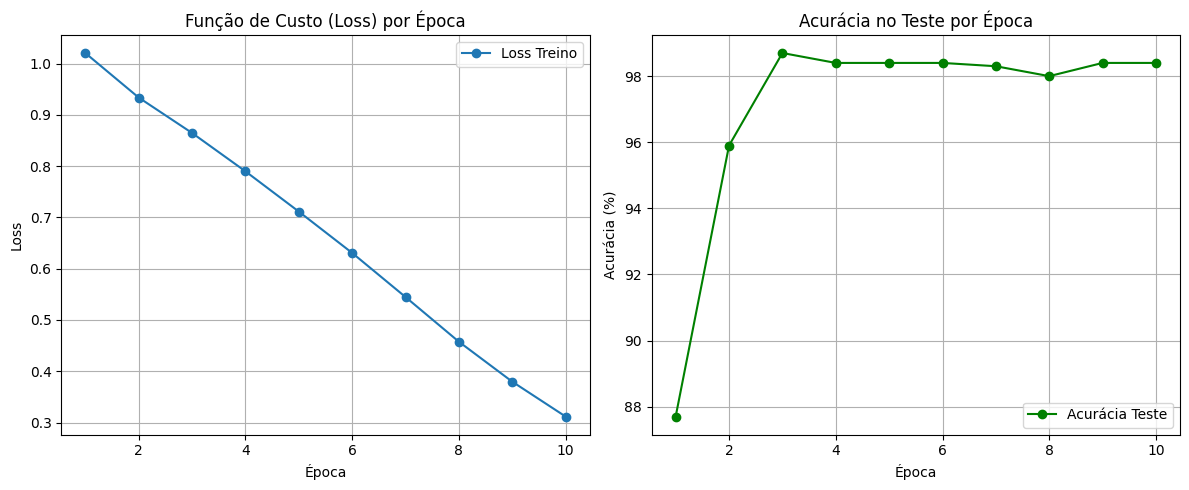

In [11]:
# Aqui carregamos o conjunto de dados MNIST (ou uma versão filtrada dele)
# 'train_size' e 'test_size' limitam a quantidade de dados para facilitar testes e treinar mais rápido
# 'batch_size' define quantas imagens são processadas de uma vez
train_loader, test_loader = load_mnist_filtered(train_size=3000, test_size=1000, batch_size=64)

# Cria uma instância do modelo híbrido quântico-clássico
# hidden_size = 5 → número de qubits e dimensão da camada intermediária
# layers = 3 → número de repetições no circuito quântico
model = Hibrido1(hidden_size=5, layers=3)

# Imprime o número total de parâmetros treináveis do modelo (útil para entender a complexidade do modelo)
print('Número de parâmetros no modelo: {}'.format(contar_parametros(model)))

# Treina o modelo usando os dados fornecidos
train_losses1, test_accuracies1 = train_model(
    model,            # o modelo híbrido a ser treinado
    train_loader,     # dados de treinamento
    test_loader,      # dados de teste (avaliação)
    num_epochs=10,    # número de vezes que o modelo verá todos os dados de treino
    lr = 0.001,       # taxa de aprendizagem
    device='cuda' if torch.cuda.is_available() else 'cpu'  # usa GPU se disponível, senão CPU
)


**Dicas de estudo**:

Analise como a quantidade de dados de treinamento pode influenciar o desempenho do modelo. Para tal, escolha outros valores para a variavel ``train_size`` da função ``load_mnist_filtered``.

Analise como o número de qubits pode influenciar o desempenho do modelo. Isso pode ser feito mudando a variavel ``hidden_size``da classe ``Hibrido1``. **OBS**: O número de qubits usados influenciara significativamente o custo computacional e o consumo de memoria. Valores muito alto podem travar o computador.

Analise como o número de camadas pode influenciar o desempenho do modelo. Para tal, mude a variavel ``layers`` da classe ``Hibrido1``. **OBS**: Como para o caso dos numero de qubits, o custo computacional e consumo de mennoria serão afetadas pelo número de camadas.

Analise como a taxa de aprendizadem influencia o desempenho do modelo. Isso pode ser feito mudando ``lr`` na função ``train_model``.

Uma boa pratica é executar o mesmo teste $N$ vezes para ver como a inicialização dos parâmetros treinaveis pode influenciar o desempenho do modelo. Execute as mesmas simlações para ver isso.

Dicas de estudo:

- Analise como a quantidade de dados de treinamento pode influenciar o desempenho do modelo. Para isso, experimente diferentes valores para a variável ``train_size`` na função ``load_mnist_filtered``.

- Analise como o número de qubits afeta o desempenho do modelo. Isso pode ser feito modificando a variável ``hidden_size`` na classe ``Hibrido1``. Observação: O número de qubits influencia significativamente o custo computacional e o uso de memória. Valores muito altos podem travar o computador.

- Analise como o número de camadas influencia o desempenho. Para isso, altere a variável ``layers`` na classe ``Hibrido1``. Observação: Assim como no caso do número de qubits, o custo computacional e o consumo de memória aumentam com o número de camadas.

- Analise como a taxa de aprendizado influencia o desempenho do modelo. Isso pode ser feito modificando o valor de ``lr``  na função ``train_model``.

- Uma boa prática é executar o mesmo experimento N vezes para observar como a inicialização dos parâmetros treináveis pode afetar o desempenho. Execute as mesmas simulações múltiplas vezes para investigar esse efeito.